In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import KFold
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression
# from sklearn import preprocessing
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
# from sklearn.svm import SVC
# import seaborn as sns
# machine learning
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import Perceptron
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,roc_curve, auc
# from sklearn.metrics import 

In [15]:
# 处理原始数据，然后合并
# 读取
df_wf = pd.read_table('../Data/House_ShangYu/wufang.txt', low_memory=False, dtype=float)
df_yf = pd.read_csv('../Data/House_ShangYu/youfang.csv', low_memory=False, dtype=float)
# 填充原始nan
df_wf = df_wf.fillna(0)
df_yf = df_yf.fillna(0)
# 处理顺序
df_wf = df_wf.reindex(columns=list(["ID","SB","GJJ","NL","CL","HY","GS","SS","Y"]))
df_yf = df_yf.reindex(columns=list(["ID","SB","GJJ","NL","CL","HY","GS","SS","Y"]))
# 填充 Y 列的目标值
df_wf["Y"] = df_wf["Y"].fillna(0)
df_yf["Y"] = df_yf["Y"].fillna(1)
# 合并，有房+0.3无房
df_wf_train, df_wf_test = train_test_split(
    df_wf, test_size=0.7)

df_house = pd.concat([df_wf_train,df_yf])
df_house = df_house.sample(frac=1)

In [16]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17665 entries, 5325 to 7717
Data columns (total 9 columns):
ID     17665 non-null float64
SB     17665 non-null float64
GJJ    17665 non-null float64
NL     17665 non-null float64
CL     17665 non-null float64
HY     17665 non-null float64
GS     17665 non-null float64
SS     17665 non-null float64
Y      17665 non-null float64
dtypes: float64(9)
memory usage: 1.3 MB


In [17]:
#有房家庭数据
df_house_x = df_house.drop(["Y", "ID"],axis=1)
df_house_view  = df_house_x;
df_house_y = df_house['Y']

# 无房家庭数据
df_wf_x = df_wf.drop(["Y", "ID"],axis=1)
df_wf_view  = df_wf_x;
df_wf_y = df_wf['Y']

In [18]:
ss = StandardScaler()
mm = MinMaxScaler()
np_house_x = mm.fit_transform(df_house_x)
df_house_x = pd.DataFrame(np_house_x)
np_wf_x = mm.fit_transform(df_wf_x)
df_wf_x = pd.DataFrame(np_wf_x)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


accuracy_score 0.9590058563062419
accuracy_score 13428
s2 0.0
roc_auc 0.9590058563062419
fpr,tpr [0.         0.95900586 1.        ]
fpr.shape (3,)


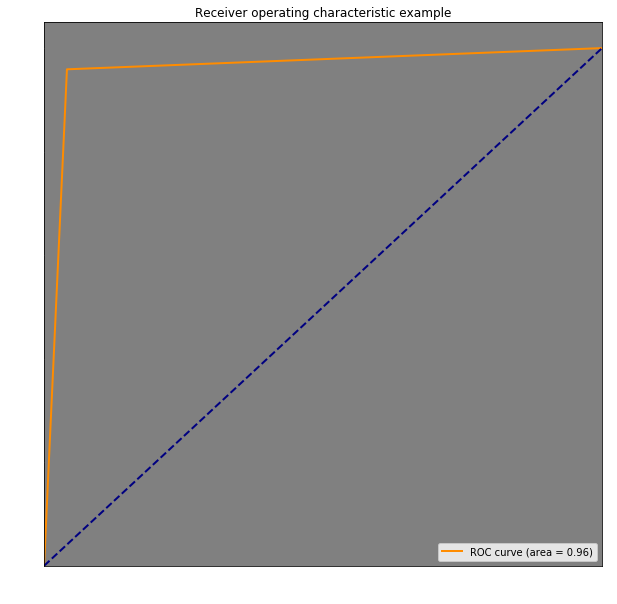

In [19]:
# 回归
model_xgb = xgb.XGBRegressor(
    booster='gbtree',
    colsample_bytree=0.8,
    gamma=0.1,
    learning_rate=0.02,
    max_depth=5,
#     n_estimators=500,
    min_child_weight=0.8,
#     reg_alpha=0,
#     reg_lambda=1,
    subsample=0.8,
    silent=1,
#     random_state=42,
    nthread=2)

model_xgb.fit(df_house_x, df_house_y)

Y_pred = model_xgb.predict(df_wf_x)
threshold = 0.5
y_pre = np.array([int(item>threshold) for  item in Y_pred])

print('accuracy_score',accuracy_score(df_wf_y, y_pre))
# normalize：默认值为True，返回正确分类的比例；如果为False，返回正确分类的样本数
print('accuracy_score',accuracy_score(df_wf_y, y_pre , normalize=False))
s2 = model_xgb.score(df_wf_x, df_wf_y)
print('s2',s2)


df_wf_y_oh = (np.arange(2) == df_wf_y[:,None]).astype(np.float32)
y_pre_oh = (np.arange(2) == y_pre[:,None]).astype(np.float32)



# print(Y_pred)

# Y_pred.itemset(1, 2)
# Y_pred.itemset(0, 1)
# Y_pred.itemset(2, 0)
# Y_pred = 1 - Y_pred
# np_wf_y = np.array(df_wf_y)
# np_wf_y.itemset(0, 1)

fpr,tpr,threshold = roc_curve(df_wf_y_oh.ravel(), y_pre_oh.ravel())
roc_auc = auc(fpr,tpr)
print('roc_auc',roc_auc)
print('fpr,tpr',tpr)
print('fpr.shape',fpr.shape)

lw = 2
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.set_facecolor('gray')
# ax.set_xlabel('fpr') 
# ax.set_ylabel('tpr') 

# 边框颜色
# ax.spines['bottom'].set_color('red') 
# ax.spines['top'].set_color('g') 
# 标签颜色
ax.xaxis.label.set_color('w') 
ax.yaxis.label.set_color('w') 

# 坐标轴颜色
ax.tick_params(axis='x', colors='w') 
ax.tick_params(axis='y', colors='w') 
# fig.patch.set_facecolor('black')

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [27]:
from sklearn.metrics import r2_score,f1_score,accuracy_score,roc_auc_score,recall_score,mean_squared_error
# print('recall_score',recall_score(df_wf_y.ravel(),Y_pred.ravel()))
# print('recall_score',recall_score(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))
# print('f1_score',f1_score(df_wf_y.ravel(),Y_pred.ravel()))
# print('f1_score',f1_score(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))
# print('accuracy_score',accuracy_score(df_wf_y.ravel(),Y_pred.ravel()))
# print('accuracy_score',accuracy_score(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))


# print('r2_score',r2_score(df_wf_y.ravel(),Y_pred.ravel()))
# print('r2_score',r2_score(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))
# print('roc_auc_score',roc_auc_score(df_wf_y.ravel(),Y_pred.ravel()))
# print('roc_auc_score',roc_auc_score(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))
# print('mean_squared_error',mean_squared_error(df_wf_y.ravel(),Y_pred.ravel()))
# print('mean_squared_error',mean_squared_error(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))

In [ ]:
# 分类
model_xgb = xgb.XGBRegressor(
    booster='gbtree',
    objective='multi:softmax',
    num_class= 2,
    colsample_bytree=0.8,
    gamma=0.1,
    learning_rate=0.02,
    max_depth=5,
#     n_estimators=500,
    min_child_weight=0.8,
#     reg_alpha=0,
#     reg_lambda=1,
    subsample=0.8,
    silent=1,
#     random_state=42,
    nthread=2)

# np_y_test = np.array(np_y_test)
model_xgb.fit(df_house_x, df_house_y)
Y_pred = model_xgb.predict(df_wf_x)

print('accuracy_score',accuracy_score(df_wf_y, Y_pred))
# normalize：默认值为True，返回正确分类的比例；如果为False，返回正确分类的样本数
print('accuracy_score',accuracy_score(df_wf_y, Y_pred , normalize=False))
score = model_xgb.score(df_wf_x, df_wf_y)
print('score',score)

df_wf_y_oh = (np.arange(2) == df_wf_y[:,None]).astype(np.float32)
Y_pred_oh = (np.arange(2) == Y_pred[:,None]).astype(np.float32)

auc_score = roc_auc_score(df_wf_y_oh, Y_pred_oh, average='micro')
print('auc_score',auc_score)
fpr,tpr,threshold = roc_curve(df_wf_y_oh.ravel(), Y_pred_oh.ravel())
roc_auc = auc(fpr,tpr)
print('roc_auc',roc_auc)
# print('fpr,tpr',fpr,tpr)
# print('threshold',threshold.shape)

lw = 2
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.set_facecolor('gray')
# ax.set_xlabel('fpr') 
# ax.set_ylabel('tpr') 

# 边框颜色
# ax.spines['bottom'].set_color('red') 
# ax.spines['top'].set_color('g') 
# 标签颜色
ax.xaxis.label.set_color('w') 
ax.yaxis.label.set_color('w') 

# 坐标轴颜色
ax.tick_params(axis='x', colors='w') 
ax.tick_params(axis='y', colors='w') 
# fig.patch.set_facecolor('black')

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [13]:
# Classification

# pre_max = np.argmax(Y_pred, 1)
# print(np.argmax(pre, 1))

print('recall_score',recall_score(df_wf_y.ravel(),Y_pred.ravel()))
print('recall_score',recall_score(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))
print('f1_score',f1_score(df_wf_y.ravel(),Y_pred.ravel()))
print('f1_score',f1_score(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))
print('accuracy_score',accuracy_score(df_wf_y.ravel(),Y_pred.ravel()))
print('accuracy_score',accuracy_score(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))

print('r2_score',r2_score(df_wf_y.ravel(),Y_pred.ravel()))
print('r2_score',r2_score(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))
# print('roc_auc_score',roc_auc_score(df_wf_y.ravel(),Y_pred.ravel()))
print('roc_auc_score',roc_auc_score(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))
print('mean_squared_error',mean_squared_error(df_wf_y.ravel(),Y_pred.ravel()))
print('mean_squared_error',mean_squared_error(df_wf_y_oh.ravel(),Y_pred_oh.ravel()))

recall_score 0.0
recall_score 0.9602913869447222
f1_score 0.0
f1_score 0.9602913869447222
accuracy_score 0.9602913869447222
accuracy_score 0.9602913869447222
r2_score 0.0
r2_score 0.8411655477788887
roc_auc_score 0.9602913869447222
mean_squared_error 0.03970861305527782
mean_squared_error 0.039708614


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


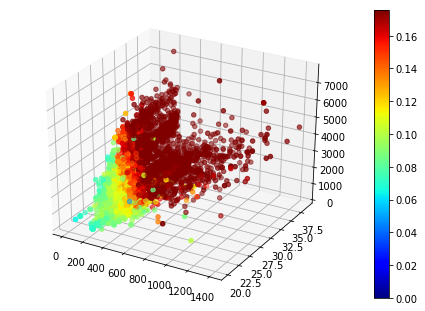

In [32]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.cm as cmx
import matplotlib
# %matplotlib qt
# %matplotlib notebook
x = df_wf_view['SB']
y = df_wf_view['NL']
z = df_wf_view['GJJ']
# values = 1 - Y_pred
values = Y_pred
# from mpl_toolkits.mplot3d import Axes3D
def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=0, vmax=cs[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    plt.show()

scatter3d(x,y,z,values)